In [1]:
# coding: utf-8
# SNLP - SoSe 2019 - ASSINGMENT v

import math
import re
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib qt 


def tokenize(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    return re.findall('[a-z]+', text.lower())

def word_ngrams(tokenized_text, n):
    return [tuple(tokenized_text[i:i + n]) for i in range(0, len(tokenized_text)-n+1)]


class ngram_LM:
    """A class to represent a language model."""

    def __init__(self, n, ngram_counts, vocab, unk=False):
        """"Make a n-gram language model, given a vocab and
            data structure for n-gram counts."""

        self.n = n

        self.vocab = vocab

        self.V = len(vocab)

        self.ngram_counts = ngram_counts

    # YOUR CODE HERE
    # START BY MAKING THE RIGHT COUNTS FOR THIS PARTICULAR self.n
        # for unigrams, we only need total word count
        if n == 1:
            self.total_count = sum(self.ngram_counts.values())
        # for bigrams, we need total count wrt each word. In our language, it is history count.
        elif n == 2:
            self.history_count = Counter()
            for k, v in self.ngram_counts.items():
                self.history_count[k[0]] = self.history_count[k[0]] + v
            # since we only count for the first word in the tuple, we will always
            # miss counting </s>. However, since the frequency of </s> is the same
            # as the frequency of <s>, we can simply assign it equal to it.
            self.history_count['</s>'] = self.history_count['<s>']



    def estimate_prob(self, history, word):
        """Estimate probability of a word given a history."""
        # YOUR CODE HERE

        if history == '':
            # unigram
            word_frequency = self.ngram_counts[tuple([word])]
            return word_frequency/self.total_count

        else:
            # bigram
            word_frequency = self.ngram_counts[tuple([history, word])]
            history_count = self.history_count[history]
            if history_count == 0:
                return 0
            return word_frequency/history_count


    def estimate_smoothed_prob(self, history, word, alpha = 0.5):
        """Estimate probability of a word given a history with Lidstone smoothing."""

        if history == '':
            # unigram
            word_frequency = self.ngram_counts[tuple([word])]
            return (word_frequency + alpha)/(alpha*self.V +self.total_count)

        else:
            # bigram
            word_frequency = self.ngram_counts[tuple([history, word])]
            history_count = self.history_count[history]
            return (word_frequency + alpha)/(alpha*self.V + history_count)


    def logP(self, history, word):
        """Return base-2 log probablity."""
        prob = self.estimate_smoothed_prob(history, word)
        log_prob = math.log(prob, 2)
        return log_prob


    def score_sentence(self, sentence):
        """Given a sentence, return score."""
        log_prob_sum = 0
        for i in range(len(sentence)):
            history = sentence[i][0]
            word = sentence[i][1]
            log_prob = self.logP(history, word)
            log_prob_sum += log_prob
        normalized_log_prob_sum = (-1 / len(sentence)) * log_prob_sum
        return normalized_log_prob_sum


    def test_LM(self):
        """Test whether or not the probability mass sums up to one."""

        precision = 10**-8

        if self.n == 1:

            P_sum = sum(self.estimate_prob('', w) for w in self.vocab)

            assert abs(1.0 - P_sum) < precision, 'Probability mass does not sum up to one.'

        elif self.n == 2:
            histories = ['the', 'in', 'at', 'blue', 'white']

            for h in histories:

                P_sum = sum(self.estimate_prob(h, w) for w in self.vocab)

                assert abs(1.0 - P_sum) < precision, 'Probability mass does not sum up to one for history' + h

        print('TEST SUCCESSFUL!')



    def test_smoohted_LM(self):
        """Test whether or not the smoothed probability mass sums up to one."""
        precision = 10**-8

        if self.n == 1:

            P_sum = sum(self.estimate_smoothed_prob('', w) for w in self.vocab)

            assert abs(1.0 - P_sum) < precision, 'Probability mass does not sum up to one.'

        elif self.n == 2:
            histories = ['the', 'in', 'at', 'blue', 'white']

            for h in histories:

                P_sum = sum(self.estimate_smoothed_prob(h, w) for w in self.vocab)

                assert abs(1.0 - P_sum) < precision, 'Probability mass does not sum up to one for history' + h

        print('TEST SUCCESSFUL!')


    def perplexity(self, test_corpus, alpha):

        likelihood = 0
        for sentence in test_corpus:
            try:
                if self.n == 1:
                    prob = self.estimate_smoothed_prob('', sentence[0], alpha)
                elif self.n ==2:
                    prob = self.estimate_smoothed_prob(sentence[0], sentence[1], alpha)
                likelihood += math.log2(prob)
            except:
                if alpha == 0:
                    continue 

        perplexity = math.pow(2, (-1*likelihood)/len(test_corpus))
        return perplexity


In [2]:
# main
filename= 'continuous.corpus.en'
with open(filename, encoding='utf-8', errors='replace') as f:
    # read entire file
    text = file.read() 

# tokenize it
tokenized_text = tokenize(text)
# print first 100 tokens to verify
unigrams = Counter(tokenized_text)

In [3]:
def calculate_PD(w1 , w2 , D, tokenized_text):
    count = 0
    N = len(tokenized_text)
    for i in range(N):
        if tokenized_text[i] == w1 and tokenized_text[i+D] == w2:
            count = count + 1
    return count/(N-D)

# 1.1 b
def correlation(w1 , w2 , D):
    total_words = len(tokenized_text)
    numerator = calculate_PD(w1, w2, D, tokenized_text) 
    denominator = (unigrams[w1]*unigrams[w2]) / (total_words * total_words)
    return numerator/denominator



In [8]:
# 1.1 c

inputs = [('you','your'),('he','his'),('he','her'),('she','her'),('they','their'),('she','his'), ('i', 'my'), ('we', 'our')]
data_points = {}
for i in range(len(inputs)):
    data_points[inputs[i]] = []
    for D in range(1,101):
        inputi = inputs[i]
        data_points[inputi].append(correlation(inputi[0],inputi[1],D))
#         print('the correlation for "{}" and "{}" for D = {} is : {}'.format(inputi[0], inputi[1], D, data_points[inputi][D-1]))

In [9]:
running_avg = {}
window_size = 5
for inputi in inputs:
    running_avg[inputi] = []
    running_avg[inputi].append([np.mean(data_points[inputi][j:j+window_size]) for j in range(101 - window_size)])


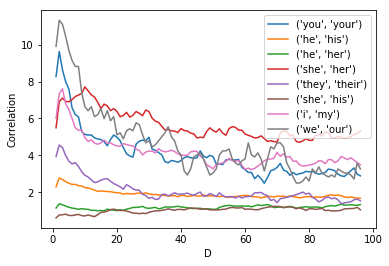

In [10]:
# part 1.1 d
Ds = [i for i in range(1,97)]
for inputi, run_avg in running_avg.items():
    plt.plot(Ds, run_avg[0])
plt.legend(running_avg.keys())
plt.xlabel('D')
plt.ylabel('Correlation')
plt.show()

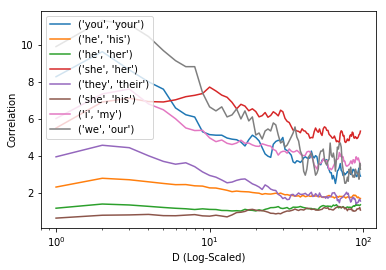

In [11]:
# part 1.1 e
for inputi, run_avg in running_avg.items():
    plt.plot(Ds, run_avg[0])
plt.legend(running_avg.keys())
plt.xscale('log')
plt.xlabel('D (Log-Scaled)')
plt.ylabel('Correlation')
plt.show()